# Objective

-----

We are starting our fast food shop but we wanna spy our competitor on what food people are buying the most from them so that we sell only high demand food to save the cost.

# Gathering Data

--------

Using DuckDuckgo library to download image dataset of various foods

In [3]:
!pip install -Uqq fastbook
from fastbook import *
from fastai.vision.widgets import *

In [5]:
ims = search_images_ddg('burger')
len(ims)

200

In [6]:
dest = 'images/burger.jpg'
download_url(ims[0], dest, show_progress = False)

Path('images/burger.jpg')

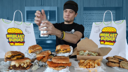

In [7]:
# Checking how it's looking

im = Image.open(dest)
im.to_thumb(128,128)

In [8]:
food_types = 'burger', 'pizza', 'chilly potato', 'momos', 'french fry', 'chowmein' , 'fried rice', 'spring roll'
path  = Path('foods')

In [9]:
if not path.exists():
    path.mkdir()
    for f in food_types:
        dest = (path/f)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(f'{f}')
        download_images(dest,  urls=results)

In [10]:
fns = get_image_files(path)
fns

(#1432) [Path('foods/burger/000991c5-5466-48e6-881c-6bebe488007a.jpg'),Path('foods/burger/0049817c-0394-4a71-9dff-c1a18415ad35.png'),Path('foods/burger/0261ba72-2202-47c3-909e-74e69d56598c.png'),Path('foods/burger/0342d019-3a06-44f1-83be-3cd8676a9c4d.png'),Path('foods/burger/03abf637-7ae4-4fda-b2a8-729e3d1e12d5.jpg'),Path('foods/burger/044112f6-6461-448e-a21e-871eba847cfb.jpg'),Path('foods/burger/047c2b0b-3a38-43c6-b8e9-4b45566a5c0e.jpg'),Path('foods/burger/050b02b6-93a9-4d55-9f6e-7b73944b84d9.jpg'),Path('foods/burger/06c25310-a58c-4584-b02c-7393a50f903a.jpg'),Path('foods/burger/0e602658-d4e8-4ff6-8605-61fe830f275d.jpg')...]

In [11]:
# Getting rid of the ones which are corrupt

failed  = verify_images(fns)
failed

(#51) [Path('foods/burger/0fcc576f-3bb9-4e8b-8658-0e258c5aa991.jpg'),Path('foods/burger/11b3f6d4-0d72-400c-94d1-5989c3ecfe8f.jpg'),Path('foods/burger/147c9f4c-1e8c-4cef-b015-d24c7fcb181e.jpg'),Path('foods/burger/16aedbad-d936-4e3a-ad02-5fc2e3117e19.jpg'),Path('foods/burger/2887d8ca-4d9d-4993-a29e-e6887d393094.jpg'),Path('foods/burger/456c100c-27e5-4268-8817-88d2113995ed.jpg'),Path('foods/burger/49e91068-1eb7-4e4f-8381-3a98948db116.jpeg'),Path('foods/burger/4ec56aa3-5588-4b50-8e26-09a89f1b1694.jpg'),Path('foods/burger/520ea522-dc65-4e05-8ca4-9b6b59503ca4.jpg'),Path('foods/burger/5ffcd7ba-c6fa-428f-bc2b-3c4d02f6a4bb.jpg')...]

In [12]:
failed.map(Path.unlink);

# Data to DataLoaders

---

We will move our data to dataloader which will classify what kind of data we have, list of items, label them and create validation set.

In [23]:
# Creating a DataBlock (A Template for creating a DataLoaders)

food = DataBlock( blocks=(ImageBlock, CategoryBlock),
                get_items=get_image_files,
                splitter=RandomSplitter(valid_pct=0.2, seed=42),
                get_y=parent_label,
                item_tfms=Resize(128))

In [24]:
# Creating Dataloaders

dls = food.dataloaders(path)

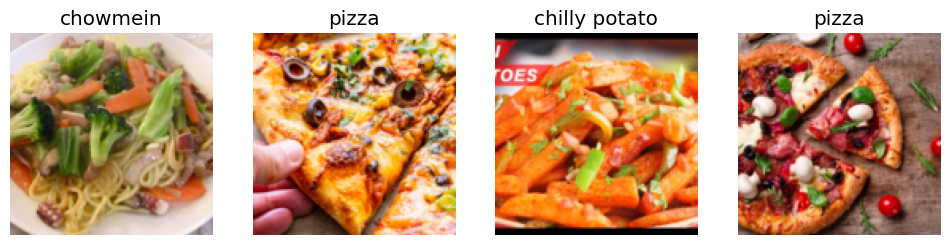

In [25]:
# Dataloader makes batches of items, using show_batch we can see items

dls.valid.show_batch(max_n=4, nrows=1)

# Training Our Model - Test 1

---

We will apply data augmentation technique first.
Then we will train our model and if we find high error rate, we will clean our data and repeat the process till we get very low error rate.

In [26]:
food  = food.new(item_tfms=RandomResizedCrop(224,min_scale=0.3), 
                 batch_tfms=aug_transforms())

dls = food.dataloaders(path)

In [27]:
# Creating our Learner and Fine_tune it

learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

C:\Users\Himz\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\Himz\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


C:\Users\Himz\anaconda3\lib\site-packages\PIL\Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


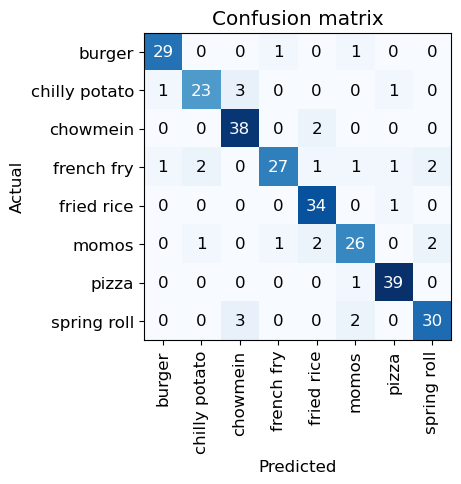

In [28]:
# Checking mistakes using Confusion matrix

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

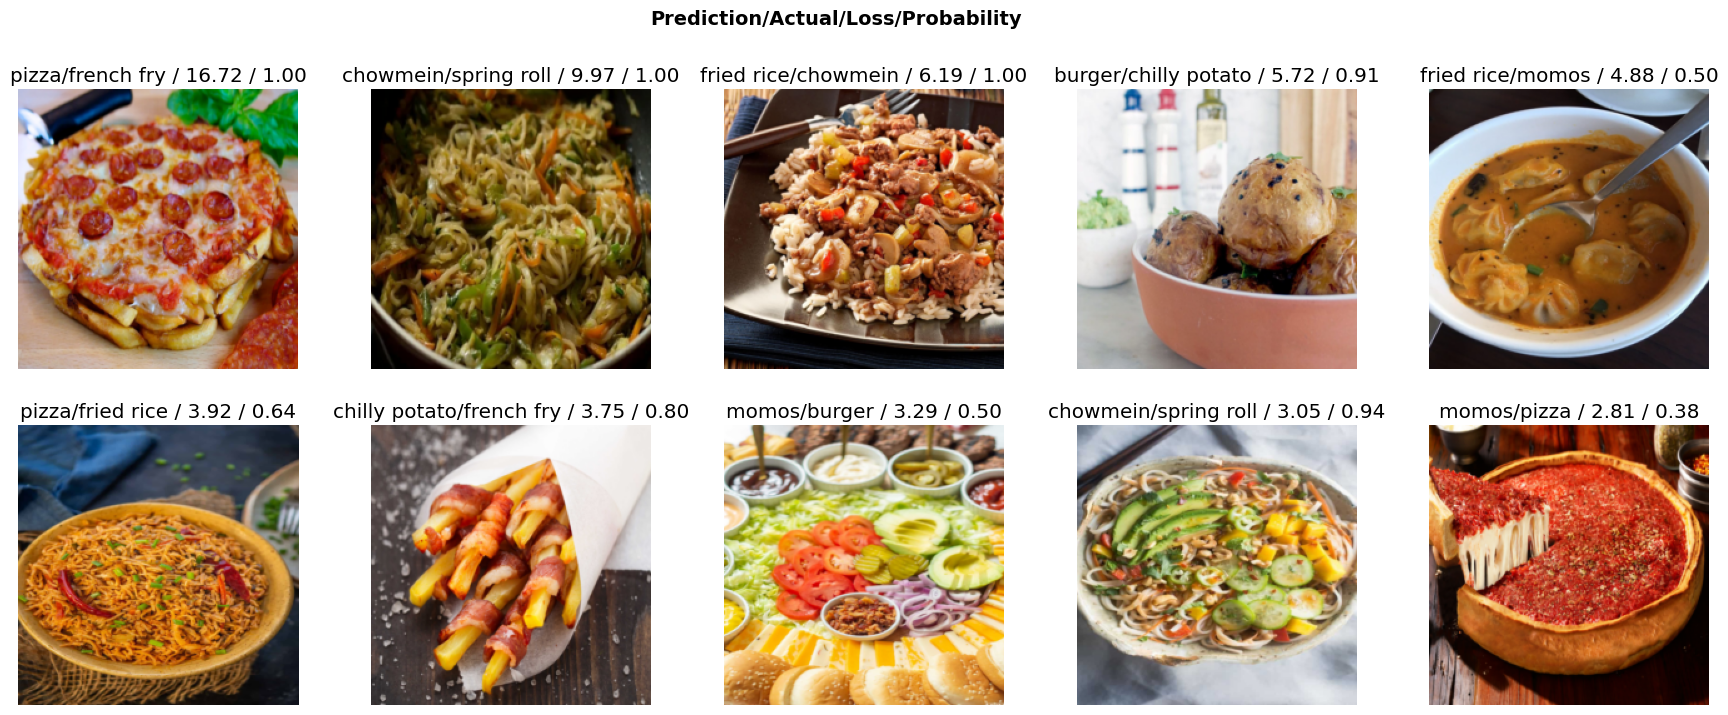

In [32]:
# We can see errors now we will plot top losses

interp.plot_top_losses(10, nrows=2, figsize=(22,8))

In [33]:
# Now we will clean our dataset using ImageClassifierCleaner

cleaner = ImageClassifierCleaner(learn)
cleaner

C:\Users\Himz\anaconda3\lib\site-packages\PIL\Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [50]:
# Cleaning or Moving pics

for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx, cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

FileNotFoundError: [WinError 2] The system cannot find the file specified: 'foods\\spring roll\\615b30c8-fcea-428a-a63d-e78b9c767710.jpg'

# Model Training - Test 2

In [52]:
food2 = DataBlock( blocks=(ImageBlock, CategoryBlock),
                get_items=get_image_files,
                splitter=RandomSplitter(valid_pct=0.2, seed=42),
                get_y=parent_label,
                item_tfms=Resize(128))

In [55]:
food2  = food2.new(item_tfms=RandomResizedCrop(224,min_scale=0.3), 
                 batch_tfms=aug_transforms())

dls2 = food2.dataloaders(path)

In [57]:
learn = vision_learner(dls2, resnet18, metrics=error_rate)
learn.fine_tune(4)

C:\Users\Himz\anaconda3\lib\site-packages\PIL\Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


C:\Users\Himz\anaconda3\lib\site-packages\PIL\Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


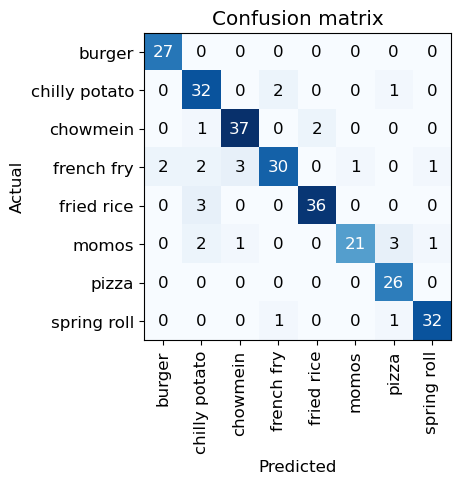

In [58]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

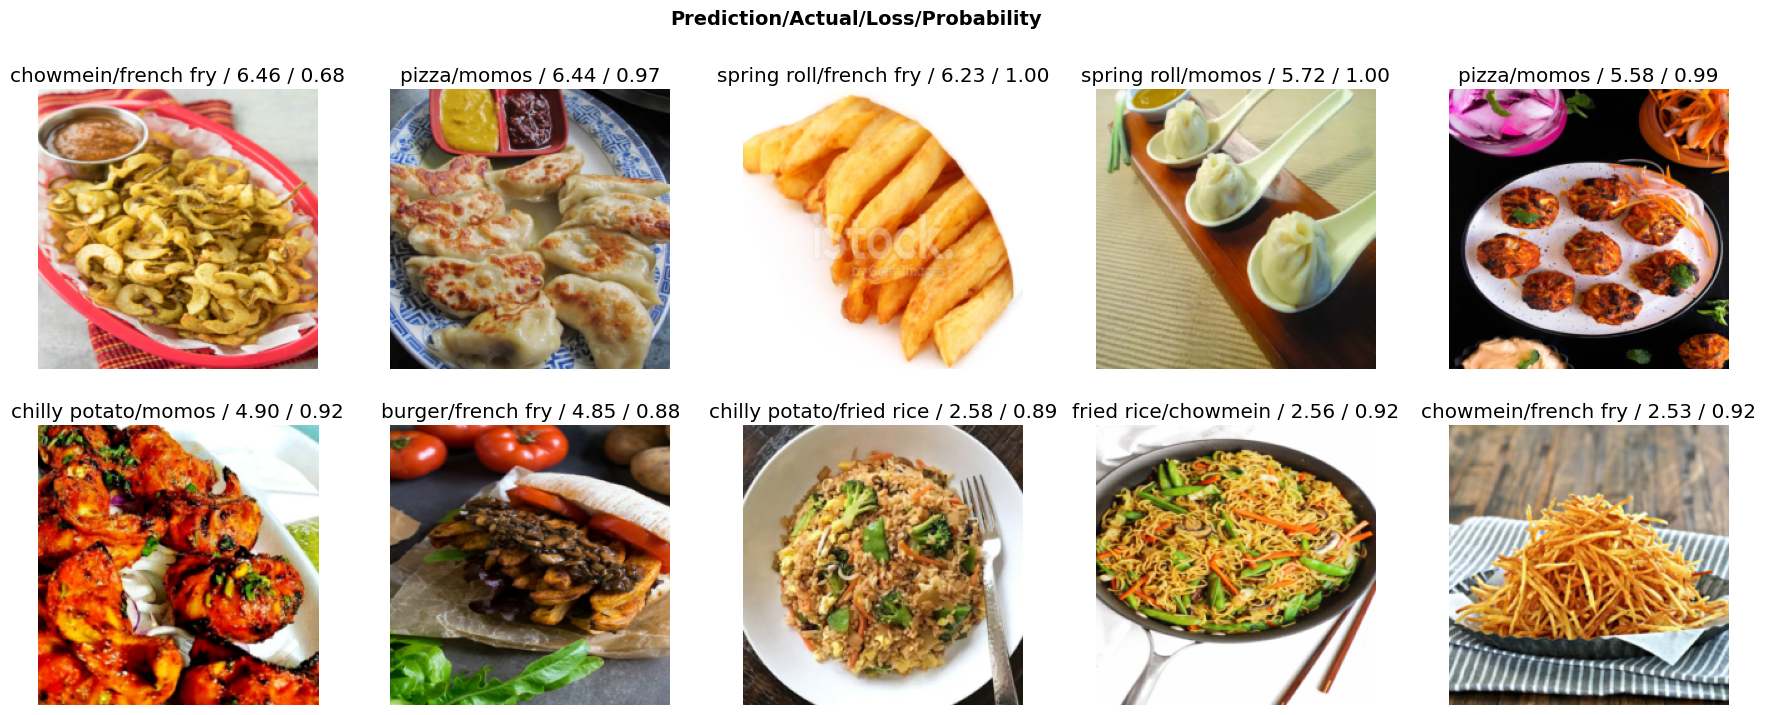

In [59]:
# We can see errors now we will plot top losses

interp.plot_top_losses(10, nrows=2, figsize=(22,8))

In [134]:
learn.export("food.pkl")

# Predictions

In [135]:
# Loading saved model

learn_inf = load_learner('food.pkl')
learn_inf.dls.vocab

['burger', 'chilly potato', 'chowmein', 'french fry', 'fried rice', 'momos', 'pizza', 'spring roll']

In [103]:
btn_upload = widgets.FileUpload()
btn_upload


FileUpload(value={}, description='Upload')

In [136]:
import cv2

img_bytes = btn_upload.data[-1]
# Read image file using OpenCV
img_array = np.frombuffer(img_bytes, np.uint8)
img_cv = cv2.imdecode(img_array, cv2.IMREAD_COLOR)

# Convert to PIL Image object
img = Image.fromarray(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))

# Make prediction using fastai learn_inf object
pred, pred_idx, probs = learn_inf.predict(img)


label_pred = widgets.Label()
label_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'



In [137]:
def on_click_classify(change):
    img_bytes = btn_upload.data[-1]
    # Read image file using OpenCV
    img_array = np.frombuffer(img_bytes, np.uint8)
    img_cv = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
    # Convert to PIL Image object
    img = Image.fromarray(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
    
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    
    pred, pred_idx, probs = learn_inf.predict(img)
    label_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.02f}'
   

In [138]:
btn_run = widgets.Button(description='Classify')

In [139]:
btn_run.on_click(on_click_classify)

In [140]:
btn_upload = widgets.FileUpload()
out_pl = widgets.Output()
label_pred = widgets.Label()

In [141]:
# Combining Upload, Run, Output and Prediction using VBox

VBox([widgets.Label('Select Your Food!'),
     btn_upload, btn_run, out_pl, label_pred])